### Function to Check Stationarity and perform ADCF Test (Augmented Dickey Fuller Test)

In [60]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Determing Rolling Stats
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot Rolling  Stats
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(movingAverage, label='Rolling Mean')
    std = plt.plot(movingSTD, label='Rolling Std')
    plt.legend(loc='best')
    
    # Perform Dickey Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-Value',
                                            '# Lags Used', 'Num of Obs Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12,8
plt.style.use('fivethirtyeight')

In [22]:
all_df = pd.read_excel('Trend.xls',sheet_name='Subs')

In [23]:
all_df.head()

,Time,VLRSubs,2GVoiceSubs,3GVoiceSubs,VoLTESubs
0,2019-01-01,6.378950e+06,2.487509e+06,1.357124e+06,472906.500000
1,2019-01-02,6.373542e+06,2.485046e+06,1.352309e+06,474875.125000
2,2019-01-03,6.373142e+06,2.481395e+06,1.350126e+06,476437.958333
3,2019-01-04,6.367197e+06,2.481166e+06,1.343412e+06,474562.125000
4,2019-01-05,6.374240e+06,2.468326e+06,1.337925e+06,482125.166667


In [24]:
all_df.dtypes

Time           datetime64[ns]
VLRSubs               float64
2GVoiceSubs           float64
3GVoiceSubs           float64
VoLTESubs             float64
dtype: object

In [25]:
all_df.columns

Index(['Time', 'VLRSubs', '2GVoiceSubs', '3GVoiceSubs', 'VoLTESubs'], dtype='object')

In [26]:
all_df.columns = ['Date', 'VLRSubs', 'VoiceSubs2G', 'VoiceSubs3G', 'VoLTESubs']

In [27]:
subs_2G = all_df.filter(['Date','VoiceSubs2G'])
subs_2G.set_index('Date',inplace=True)

In [28]:
subs_2G.head(5)

,VoiceSubs2G
Date,
2019-01-01,2.487509e+06
2019-01-02,2.485046e+06
2019-01-03,2.481395e+06
2019-01-04,2.481166e+06
2019-01-05,2.468326e+06


#  Check Stationarity of Data

### 1) From Plot of Dataset
##### If checked mean of Apr2019 > mean of Jul2020, indicating that data is not stationary

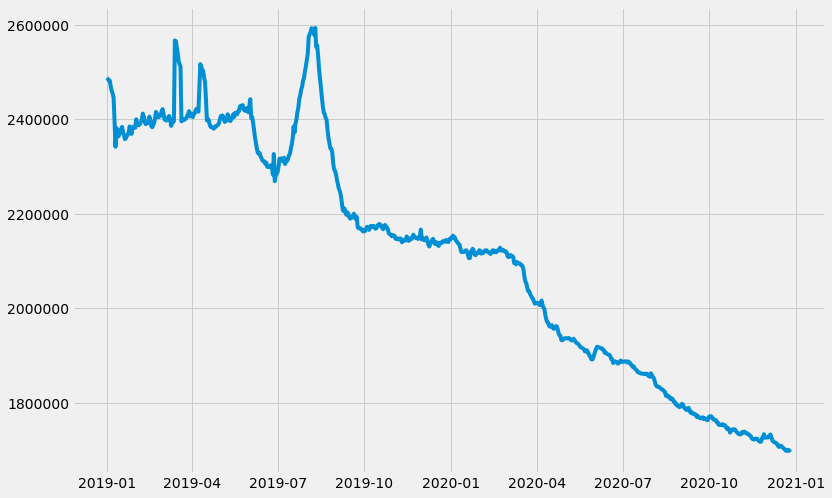

In [29]:
plt.plot(subs_2G)

### 2) Check by Rolling Statistics

##### From Rolling mean plot, its confirmed that data is on increasing trend and is not stationary

In [30]:
rolmean = subs_2G.rolling(window=30).mean()
rolstd = subs_2G.rolling(window=30).std()

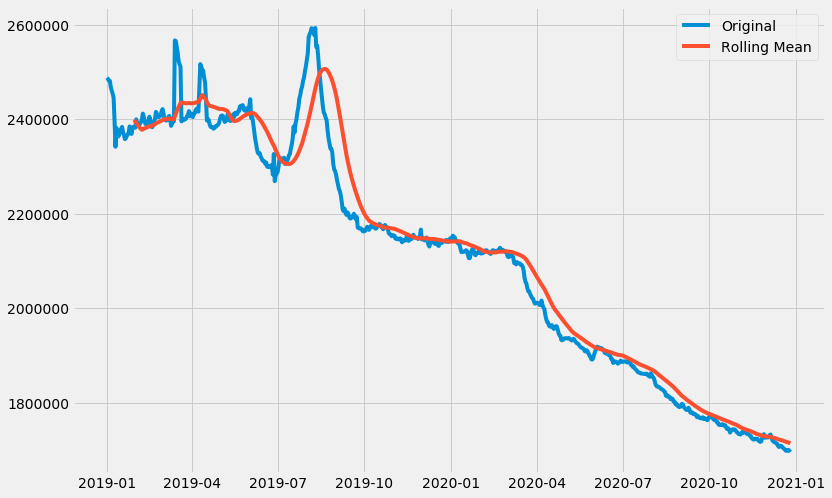

In [31]:
orig = plt.plot(subs_2G, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
#std = plt.plot(rolstd, label='Rolling Std')
plt.legend(loc='best')

### 3) Check by Dickey-Fuller Test

##### From Rolling mean plot, its confirmed that data is on increasing trend and is not stationary
##### p-Value should be around 0.5 and Critical Value should be similar to Test Statistic to indicate data is stationary

Results of Dickey-Fuller Test:
Test Statistic           -0.222449
p-Value                   0.935792
# Lags Used               8.000000
Num of Obs Used         717.000000
Critical Value (1%)      -3.439503
Critical Value (5%)      -2.865579
Critical Value (10%)     -2.568921
dtype: float64


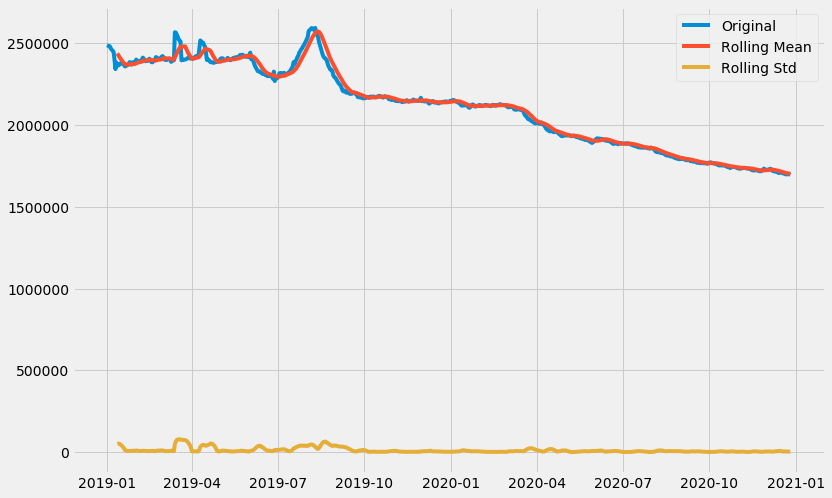

In [32]:
test_stationarity(subs_2G)

# Estimate Trend on Log Scale
#### Plotting on log scale along wih moving avg of log scale, Data again indicates it is not stationary

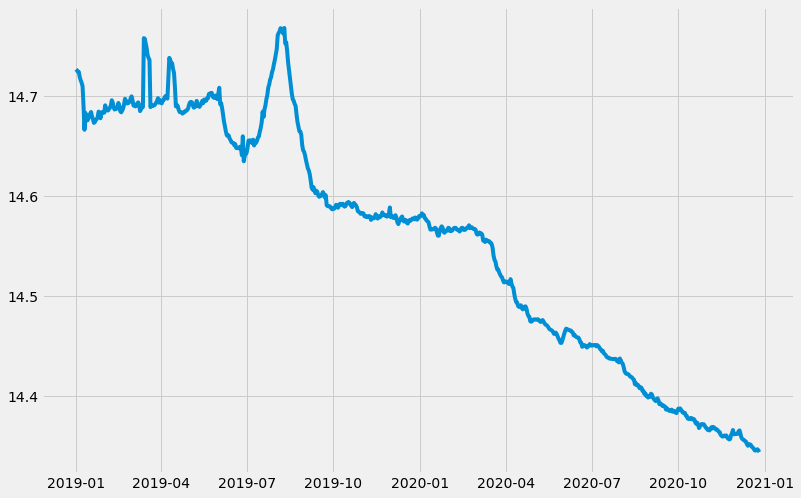

In [34]:
subs_2G_logScale = np.log(subs_2G)
plt.plot(subs_2G_logScale)

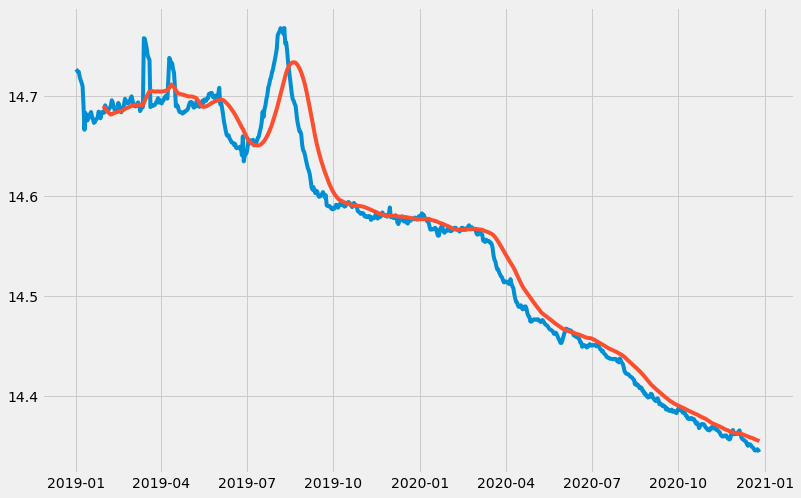

In [36]:
movingAverage = subs_2G_logScale.rolling(window=30).mean()
movingSTD = subs_2G_logScale.rolling(window=30).std()

plt.plot(subs_2G_logScale)
plt.plot(movingAverage)
#plt.plot(movingSTD)

# Convert Time Series to Stationary

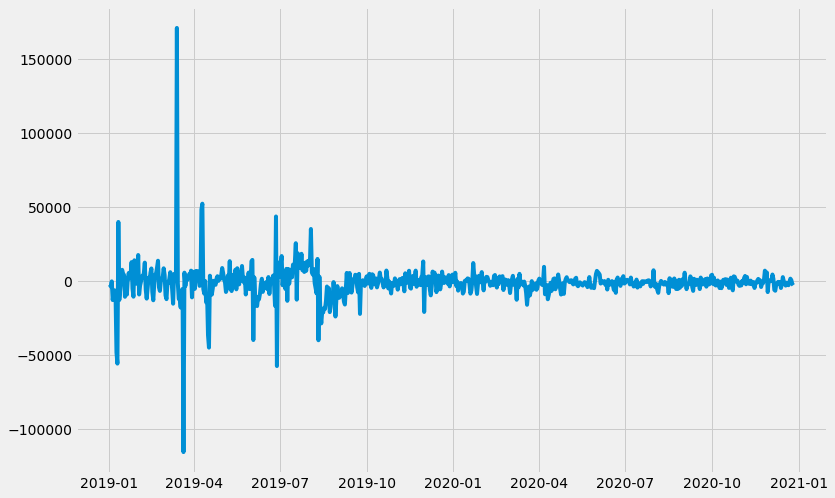

In [38]:
subs_2GDiffShifting = subs_2G - subs_2G.shift()
plt.plot(subs_2GDiffShifting)

Results of Dickey-Fuller Test:
Test Statistic           -5.324518
p-Value                   0.000005
# Lags Used              20.000000
Num of Obs Used         704.000000
Critical Value (1%)      -3.439673
Critical Value (5%)      -2.865654
Critical Value (10%)     -2.568961
dtype: float64


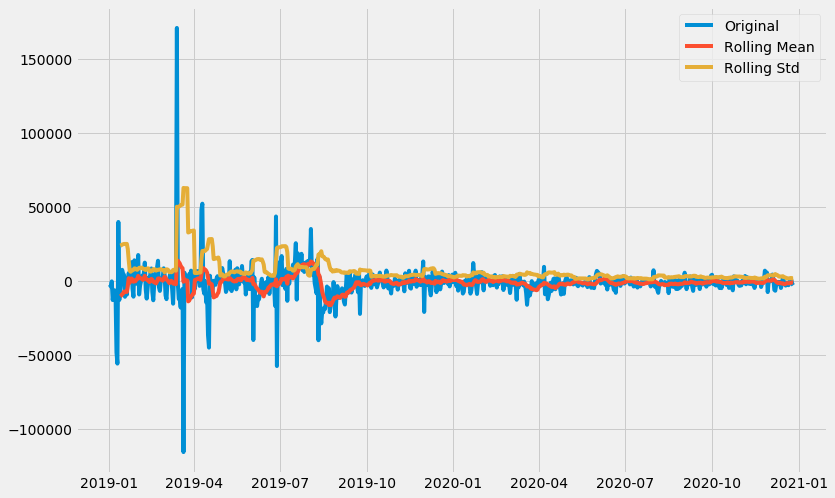

In [61]:
# Remove Null Values and test Stationarity
# Test indicates that Data is stationary
# Also since we did shifting once to make data stationary, so 'd'=1 in ARIMA
subs_2GDiffShifting.dropna(inplace=True)
test_stationarity(subs_2GDiffShifting)

# Decomposition of Time Series
#### 1) Trend
#### 2) Seasonality
#### 3) Residual

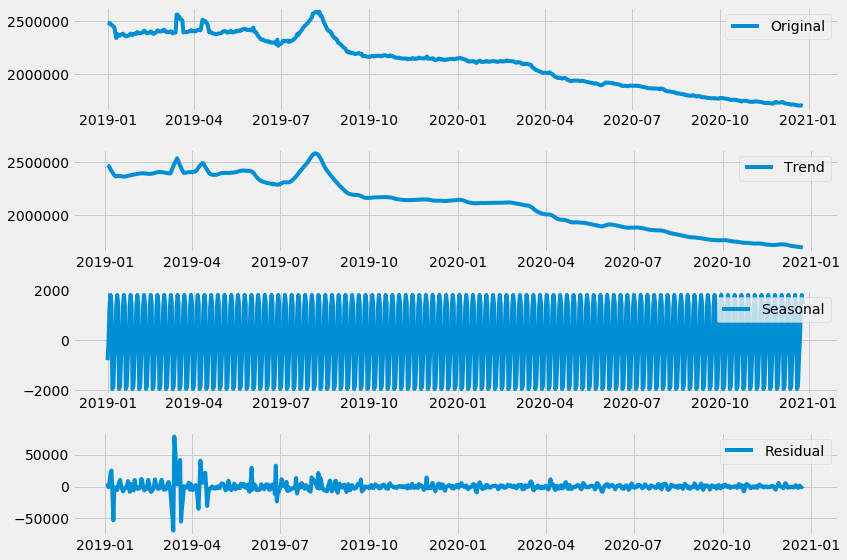

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(subs_2G)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(subs_2G, label = 'Original')
plt.legend(loc='upper right')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='upper right')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='upper right')
plt.tight_layout()

# Make ACF and PACF Plots to get values of p (AR part) and q (MA part)

In [44]:
from statsmodels.tsa.stattools import acf, pacf

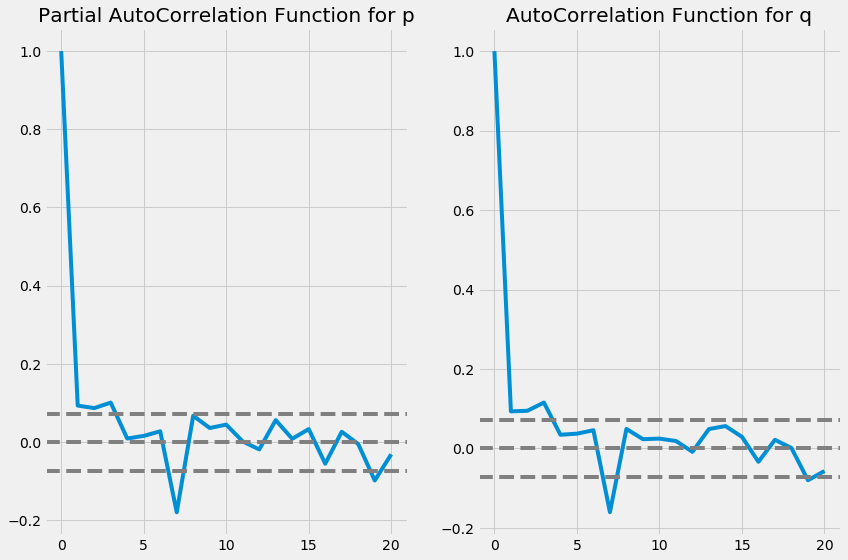

In [46]:
lag_acf = acf(subs_2GDiffShifting, nlags=20)
lag_pacf = pacf(subs_2GDiffShifting, nlags=20, method = 'ols')
# ols = ordinary least sqaure method
# nlags from Dickey Fuller Test i.e. 20

# Plot PACF
# Check where line drops to confidence level i.e. close to 0
# From below chart value of p=3
plt.subplot(121)
plt.plot(lag_pacf)
# Confidence Levels
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(subs_2GDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(subs_2GDiffShifting)),linestyle='--',color='gray')
plt.title('Partial AutoCorrelation Function for p')

# Plot ACF
# Check where line drops to confidence level i.e. close to 0
# From below chart value of d=3
plt.subplot(122)
plt.plot(lag_acf)
# Confidence Levels
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(subs_2GDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(subs_2GDiffShifting)),linestyle='--',color='gray')
plt.title('AutoCorrelation Function for q')
plt.tight_layout()

# Run ARIMA Model
##### p = 3 (From PACF graph)
##### d = 1 (From the count of shifting required to make data stationary)
##### q = 3 (From ACF Graph)

In [47]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 89567093665.9579')

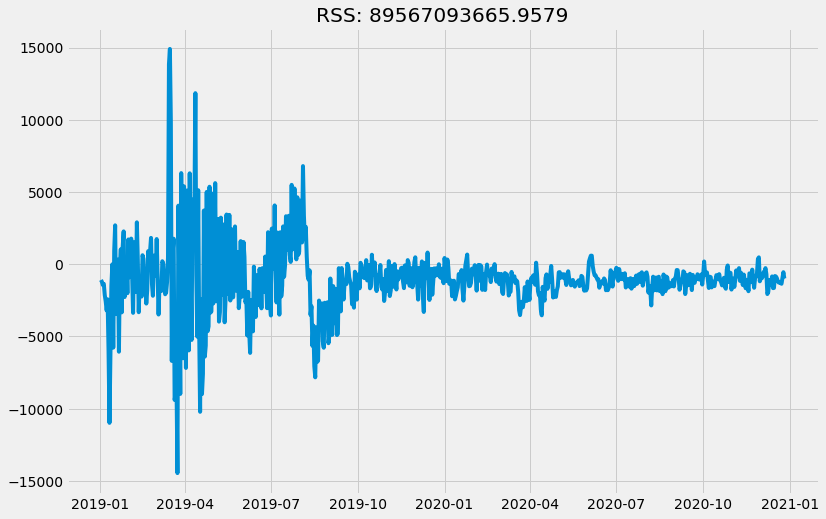

In [48]:
model = ARIMA(subs_2G, order = (3,1,3) )
results_ARIMA = model.fit(disp=-1)

plt.plot(results_ARIMA.fittedvalues)
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - subs_2GDiffShifting['VoiceSubs2G'])**2))
# RSS = Residual sum of square, lower value is better

#  Calculate and Plot Future Predicted Values
#### Check number of datapoints in original dataset and then do prediction on (originalDataPoints + pointsRequiredInFuture)

In [49]:
subs_2G.shape

(726, 1)

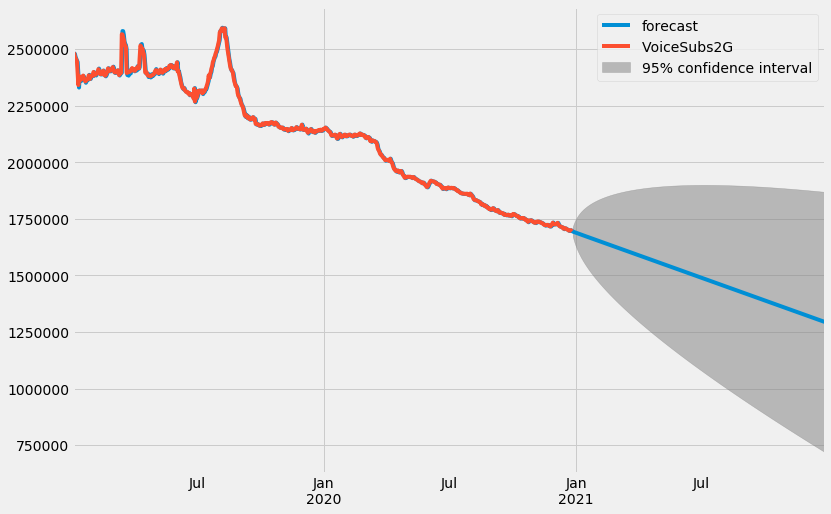

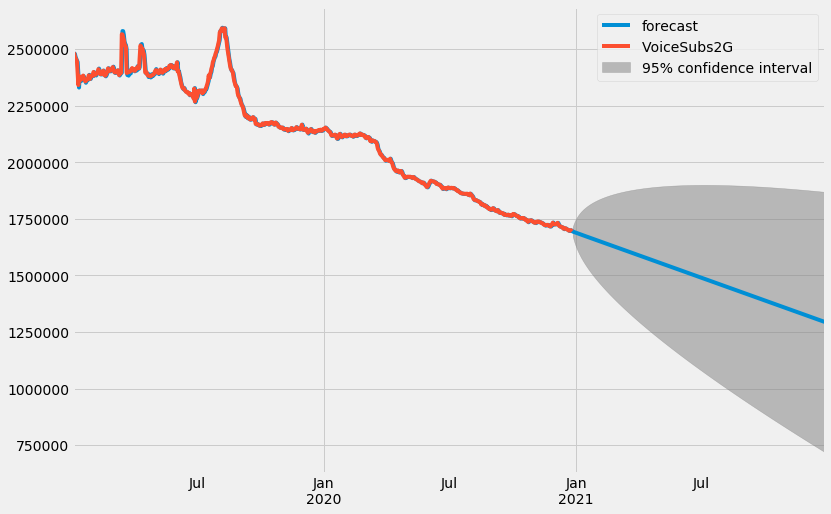

In [50]:
# Predict data for 1 Year, i.e. 365 points
# Now totat data points will be {726+365} 1091 points 
results_ARIMA.plot_predict(1,1091)

In [59]:
subs_2G.iloc[:,0]

Date
2019-01-01    2.487509e+06
2019-01-02    2.485046e+06
2019-01-03    2.481395e+06
2019-01-04    2.481166e+06
2019-01-05    2.468326e+06
2019-01-06    2.460254e+06
2019-01-07    2.453996e+06
2019-01-08    2.445558e+06
2019-01-09    2.397261e+06
2019-01-10    2.341429e+06
2019-01-11    2.381406e+06
2019-01-12    2.368572e+06
2019-01-13    2.363177e+06
2019-01-14    2.366736e+06
2019-01-15    2.374356e+06
2019-01-16    2.379323e+06
2019-01-17    2.383448e+06
2019-01-18    2.372808e+06
2019-01-19    2.366802e+06
2019-01-20    2.357623e+06
2019-01-21    2.359395e+06
2019-01-22    2.364862e+06
2019-01-23    2.366721e+06
2019-01-24    2.371607e+06
2019-01-25    2.384417e+06
2019-01-26    2.379198e+06
2019-01-27    2.368623e+06
2019-01-28    2.382670e+06
2019-01-29    2.381237e+06
2019-01-30    2.383813e+06
                  ...     
2020-11-27    1.727502e+06
2020-11-28    1.733366e+06
2020-11-29    1.725914e+06
2020-11-30    1.726150e+06
2020-12-01    1.726586e+06
2020-12-02    1.726466e